In [23]:
import matplotlib.pyplot as plt
import corner as corner
import pandas as pd
import numpy as np
import h5py
import torch
import time
from scipy.special import logsumexp
from functools import reduce
import operator
from copy import deepcopy

import sys

sys.path.append('../')
from populations.bbh_models import get_models
import populations.bbh_models as read_models
from populations.utils.flow import NFlow
from populations.Flowsclass_dev import FlowModel
from populations import gw_obs
from populations.bbh_models import read_hdf5

from sample import sample as samp

In [2]:
param = ['mchirp','q', 'chieff', 'z']
param_label = ['Chirp Mass /$M_{\odot}$','Mass Ratio', 'Effective Spin', 'Redshift']

no_params = len(param)
channel_label = ['CE', 'CHE','GC','NSC', 'SMT']

models_path ='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'

In [35]:
params = ['mchirp','q', 'chieff', 'z']
chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gw_events'
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', None)

model_names, flow = read_models.get_models(file_path, channel_label, params, use_flows=True, device='cpu', no_bins=[5,4,4,5,4], use_unityweights=False)
_, KDE = read_models.get_models(file_path, channel_label, params, use_flows=False, device='cpu', use_unityweights=False)

100%|██████████| 36/36 [00:14<00:00,  2.55it/s]


In [36]:
#inputs: x, data, pop_models, submodels_dict, channels, use_flows
channels = sorted(list(set([x.split('/')[0] for x in model_names])))
model_names.sort()
hyperparams = sorted(list(set([x.split('/', 1)[1] for x in model_names])))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])

hyperparam_dict  = {}
hyperidx=0
while hyperidx < Nhyper:
    hyperidx_with_Nhyper = np.argwhere(np.asarray([len(x.split('/')) for x in hyperparams])>hyperidx).flatten()
    hyperparams_at_level = sorted(set([x.split('/')[hyperidx] for x in np.asarray(hyperparams)[hyperidx_with_Nhyper]]))
    hyperparam_dict[hyperidx] = hyperparams_at_level
    hyperidx += 1


# ---  Copy kde_models so that they all have the same levels of hyperparameters
def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)
def setInDict(dataDict, mapList, value):
    getFromDict(dataDict, mapList[:-1])[mapList[-1]] = value
    
all_models_at_deepest = all([len(x.split('/')[1:])==Nhyper for x in model_names])
while all_models_at_deepest==False:
    # loop until all models have the same length
    for model in model_names:
        # See number of hyperparameters in model, subtract one for channel
        Nhyper_in_model = len(model.split('/'))-1
        kde_hold = getFromDict(KDE, model.split('/'))
        # loop until this model has all the hyperparam levels as well
        print(Nhyper_in_model)
        while Nhyper_in_model < Nhyper:
            # remove kde model from old level
            setInDict(KDE, model.split('/'), {})
            model_names.remove(model)
            for new_hyperparam in hyperparam_dict[Nhyper_in_model]:
                # copy the same kde model for the higher hyperparam level
                new_kde = deepcopy(kde_hold)
                new_level = model.split('/') + [new_hyperparam]
                setInDict(KDE, new_level, new_kde)
                print(new_level)
                # add new model name
                model_names.append(model+'/'+new_hyperparam)
            Nhyper_in_model += 1
        model_names.sort()
    # see if all models are at deepest level else repeat
    all_models_at_deepest = all([len(x.split('/')[1:])==Nhyper for x in model_names])


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
['CHE', 'chi00', 'alpha02']
['CHE', 'chi00', 'alpha05']
['CHE', 'chi00', 'alpha10']
['CHE', 'chi00', 'alpha20']
['CHE', 'chi00', 'alpha50']
2
2
2
2
1
['CHE', 'chi01', 'alpha02']
['CHE', 'chi01', 'alpha05']
['CHE', 'chi01', 'alpha10']
['CHE', 'chi01', 'alpha20']
['CHE', 'chi01', 'alpha50']
2
2
2
2
1
['CHE', 'chi02', 'alpha02']
['CHE', 'chi02', 'alpha05']
['CHE', 'chi02', 'alpha10']
['CHE', 'chi02', 'alpha20']
['CHE', 'chi02', 'alpha50']
2
2
2
2
1
['CHE', 'chi05', 'alpha02']
['CHE', 'chi05', 'alpha05']
['CHE', 'chi05', 'alpha10']
['CHE', 'chi05', 'alpha20']
['CHE', 'chi05', 'alpha50']
2
2
2
2
1
['GC', 'chi00', 'alpha02']
['GC', 'chi00', 'alpha05']
['GC', 'chi00', 'alpha10']
['GC', 'chi00', 'alpha20']
['GC', 'chi00', 'alpha50']
2
2
2
2
1
['GC', 'chi01', 'alpha02']
['GC', 'chi01', 'alpha05']
['GC', 'chi01', 'alpha10']
['GC', 'chi01', 'alpha20']
['GC', 'chi01', 'alpha50']
2
2
2
2
1
['GC', 'chi02', 'alpha02']
['GC', 'chi02', 'alpha05']
['GC', 'chi02'

IndexError: list index out of range

In [44]:

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

In [45]:
flow_path="/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/Flows_230124_100000epochs/flow_models/"
for i, channel in enumerate(channel_label):
    flow[channel].load_model(flow_path, channel)

## 2D over mchirp-q

In [56]:
mchirps = np.linspace(0.1,49.9,20)
qs = np.linspace(0.01,0.99,20)

p_mchirpq = np.zeros((4,5,20,20))
p_mchirpq_kde = np.zeros((4,5,20,20))

chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        for  i, m in enumerate(mchirps):
            for j, q in enumerate(qs):
                sample = np.reshape([m, q,0.0,0.2], (1,1,4))
                p_mchirpq[chibid, alphaid, i, j] = samp.lnlike([xb,a,0.5,0.05,0.2,0.1], sample, flow, submodels_dict, channels, use_flows=True, prior_pdf=None, use_reg=True, smallest_n=9909)
                p_mchirpq_kde[chibid, alphaid, i, j] = samp.lnlike([chibid,alphaid,0.5,0.05,0.2,0.1], sample, KDE, submodels_dict, channels, use_flows=False, prior_pdf=None,use_reg=True, smallest_n=9909)
        print(xb,a)

[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00011657]
[0.00010091]
[0.0001013]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010985]
[0.0001011]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010694]
[0.0001014]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010197]
[0.00010121]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010093]
[0.00010139]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010149]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010551]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010313]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010242]
[0.00010091]
[0

In [51]:
chi_b = [0.0]
alpha = [0.2]

flow_likelihood = np.zeros((20,20))
kde_likelihood = np.zeros((20,20))

for chibid, xb in enumerate(chi_b):
    for alphaid, a  in enumerate(alpha):
        for  i, m in enumerate(mchirps):
            for j, q in enumerate(qs):
                sample = np.reshape([m, q,0.0,0.2], (1,1,4))
                flow_likelihood[i, j] = samp.lnlike([xb,a,0.5,0.05,0.2,0.1], sample, flow, submodels_dict, channels, use_flows=True, prior_pdf=None, use_reg=True, smallest_n=9909)
                kde_likelihood[i, j] = samp.lnlike([chibid,alphaid, 0.5,0.05,0.2,0.1], sample, KDE, submodels_dict, channels, use_flows=False, prior_pdf=None,use_reg=True, smallest_n=9909)


[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00011657]
[0.00010091]
[0.0001013]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010985]
[0.0001011]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010694]
[0.0001014]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010197]
[0.00010121]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010093]
[0.00010139]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010149]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010551]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010313]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010091]
[0.00010242]
[0.00010091]
[0

In [17]:
np.save('llh_ratio/slices/allchannels2Dmchirpq_chi0_z02_p_flow_9909smallestn.npy', p_mchirpq, allow_pickle=True)
np.save('llh_ratio/slices/allchannels2Dmchirpq_chi0_z02_p_KDE_9909smallestn.npy', p_mchirpq_kde, allow_pickle=True)

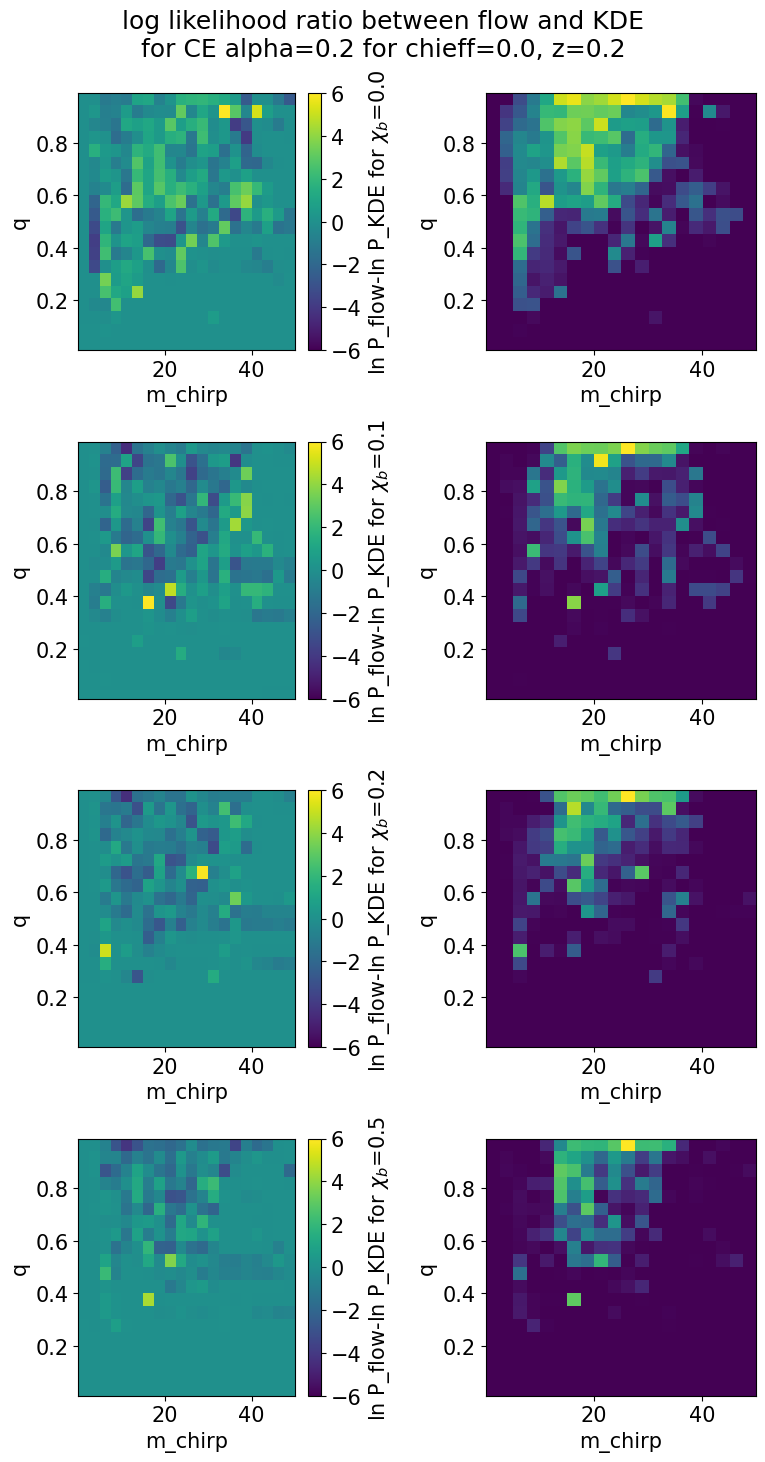

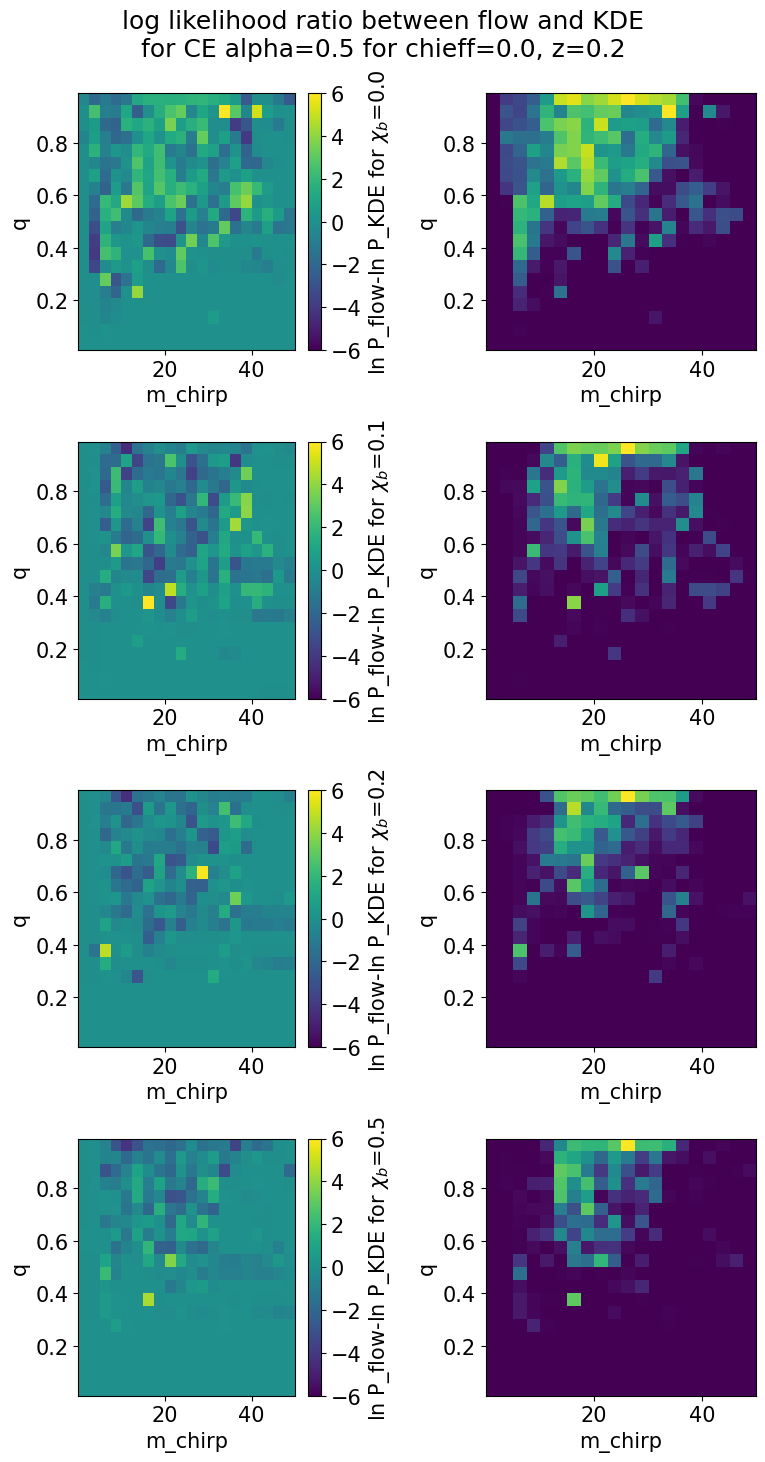

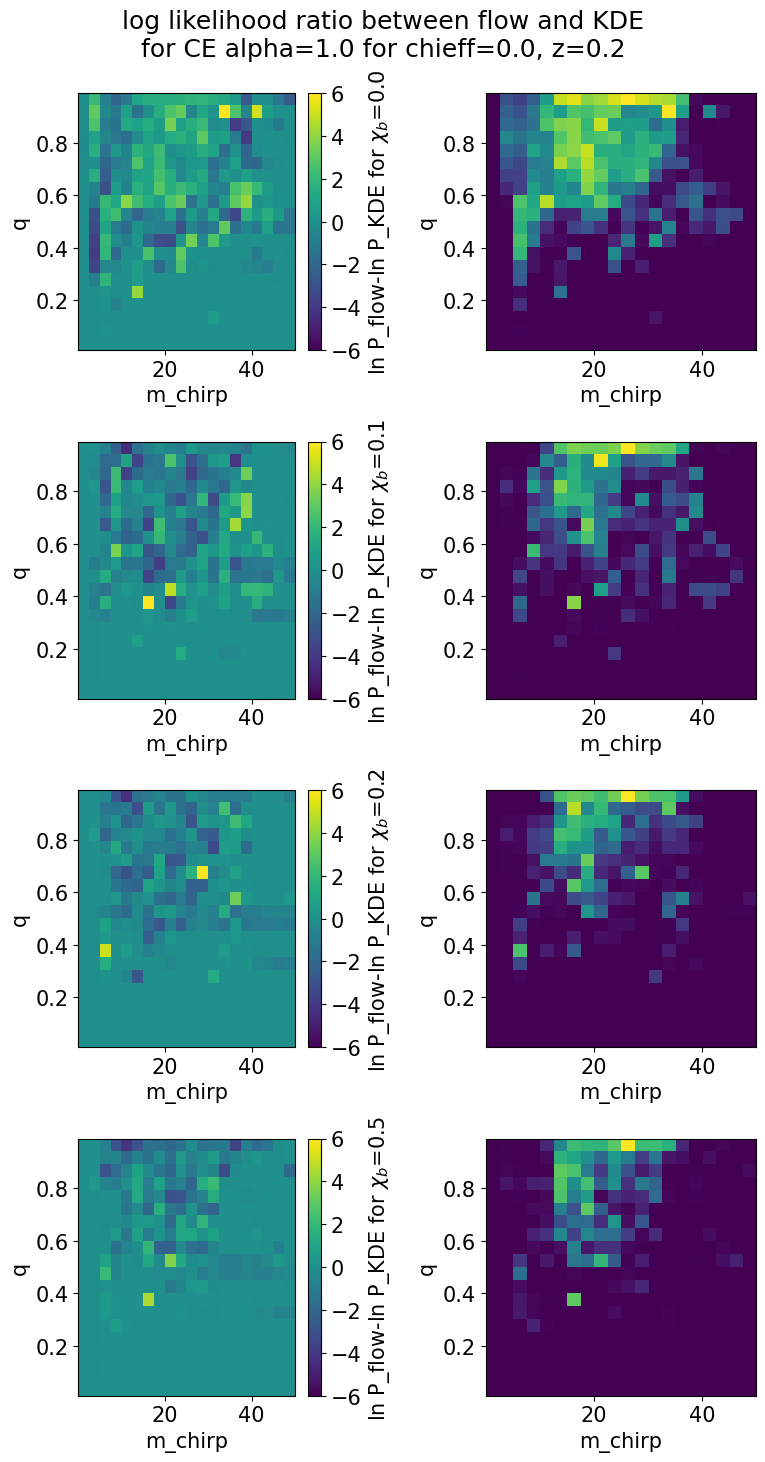

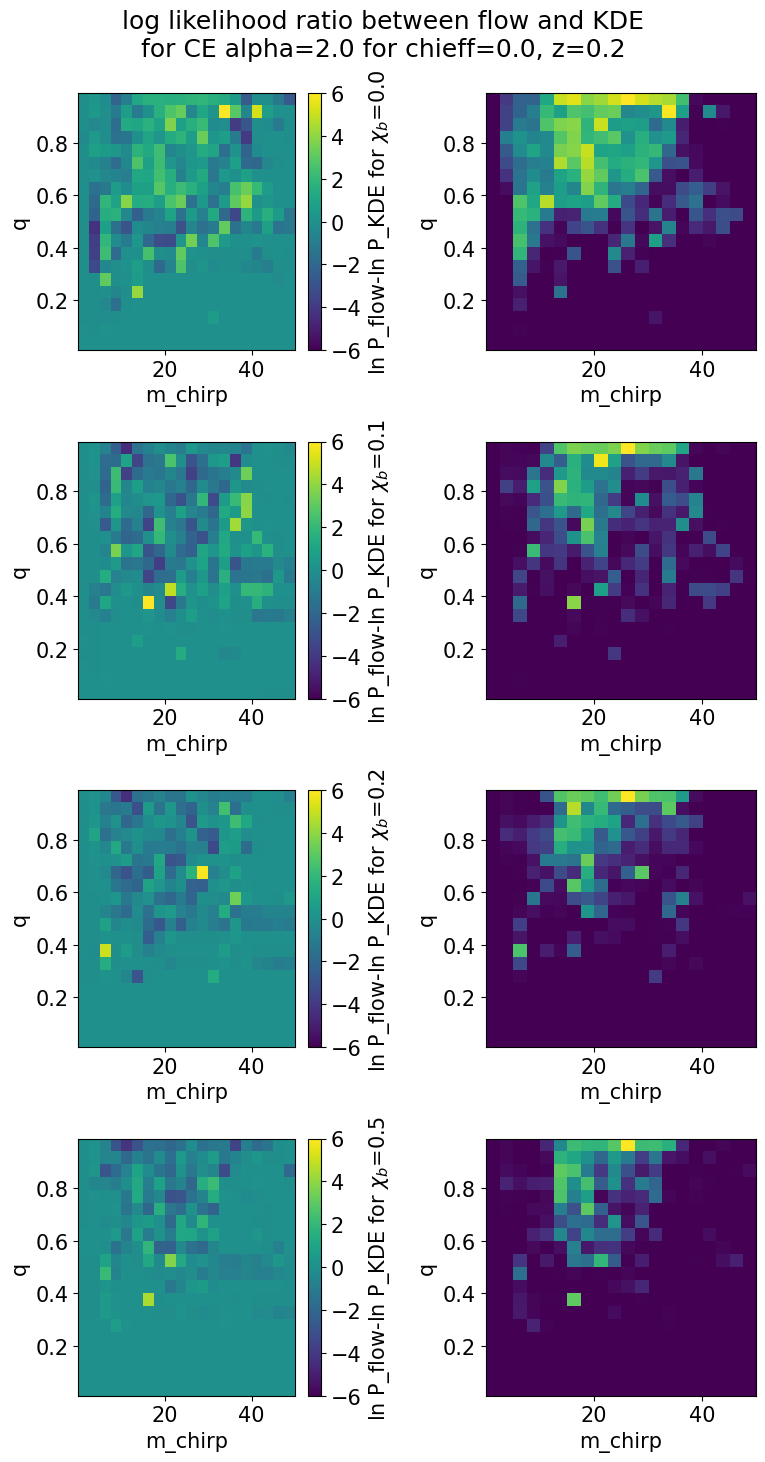

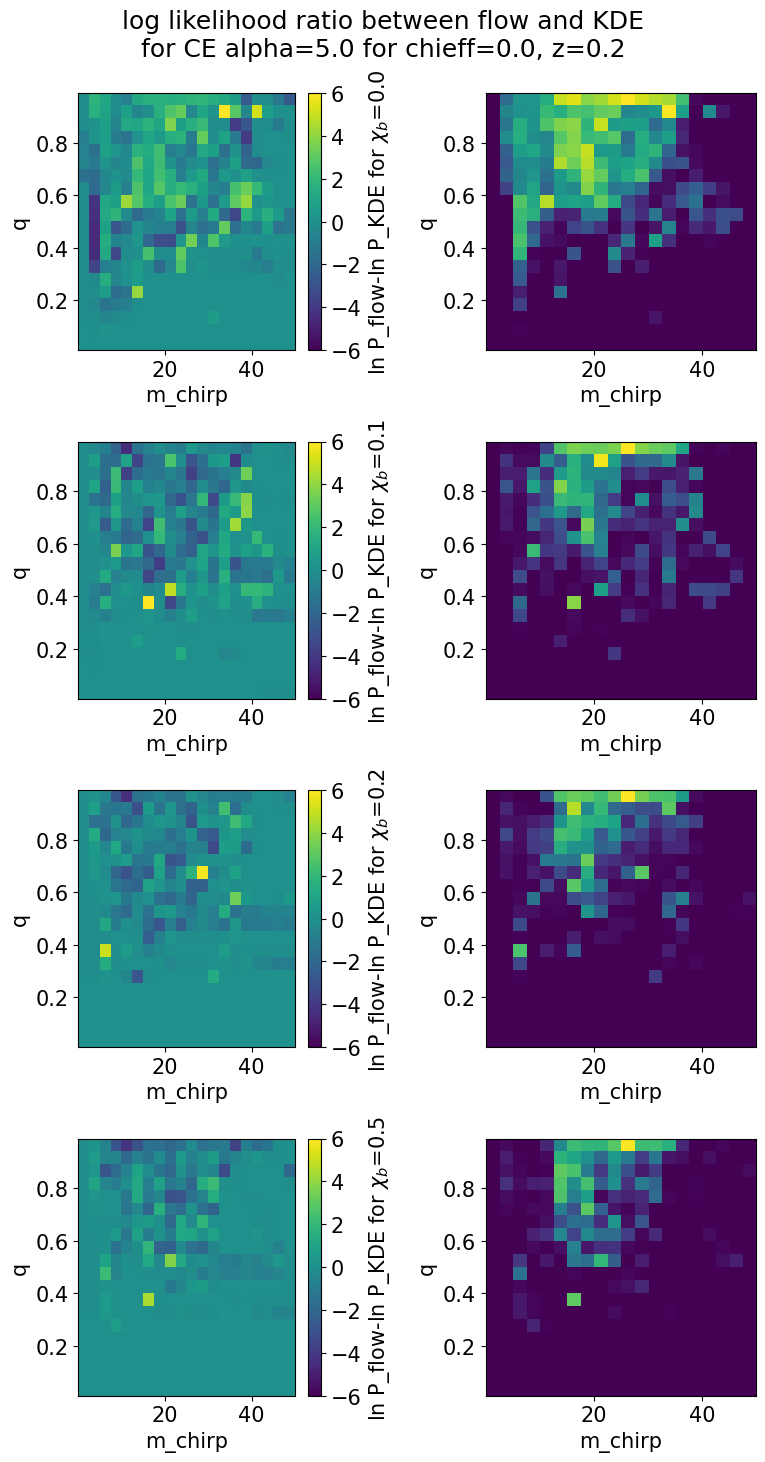

In [59]:
plt.rcParams["figure.figsize"] = (8,15)
plt.rcParams.update({'font.size': 15})

for alphaid in range(5):
    fig, ax = plt.subplots(4,2)
    for chibid in range(4):
        ratio = p_mchirpq[chibid, alphaid,:,:]-p_mchirpq_kde[chibid, alphaid,:,:]
        #oldratio = strict_reg_flow[chibid, alphaid,:,:]-strct_reg_KDE[chibid, alphaid,:,:]
        c = ax[chibid,0].imshow(np.swapaxes(ratio, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto')
        ax[chibid,1].imshow(np.swapaxes(p_mchirpq[chibid, alphaid,:,:], 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', aspect='auto')

        cbar = fig.colorbar(c, ax=ax[chibid,0])
        cbar.set_label(fr'ln P_flow-ln P_KDE for $\chi_b$={chi_b[chibid]}')
        #c = ax[chibid,1].imshow(np.swapaxes(oldratio, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto')


        ax[chibid,0].set_xlabel(fr'm_chirp')
        ax[chibid,1].set_xlabel(fr'm_chirp')
        ax[chibid,0].set_ylabel(fr'q')

        """ bin_width = 0.05
        chieffs = models_dict[(chibid,alphaid)][:]['chieff']
        zs = models_dict[(chibid,alphaid)][:]['z']
        bin_chieff = np.logical_and(chieffs>0.0 - 2*bin_width,  chieffs< 0.0 + 2*bin_width)
        bin_z = np.logical_and(zs>0.2 - 10*bin_width, zs < 0.2 + 10*bin_width)
        bin_conditions = np.logical_and(bin_chieff, bin_z)

        c = ax[chibid,1].imshow(np.swapaxes(ratio,0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto', zorder=-200)

        corner.hist2d(np.array(models_dict[(chibid,alphaid)][bin_conditions]['mchirp']), np.array(models_dict[(chibid,alphaid)][bin_conditions]['q']),\
             weights=np.array(weights_dict[(chibid,alphaid)][bin_conditions]), alpha=0.5, density=True, ax=ax[chibid,1], no_fill_contours=True)
        """
        ax[chibid,1].set_xlim(mchirps[0], mchirps[-1])
        ax[chibid,1].set_ylim(qs[0], qs[-1])
        ax[chibid,1].set_xlabel(fr'm_chirp')
        ax[chibid,1].set_ylabel(fr'q')
    fig.suptitle('log likelihood ratio between flow and KDE''\n'fr'for CE alpha={alpha[alphaid]} for chieff=0.0, z=0.2')
    fig.tight_layout(pad=1.3)
    #fig.savefig(f'llh_ratio/slices/CE2Dmchirpq_chi0_z02_alpha{alpha[alphaid]}.pdf')

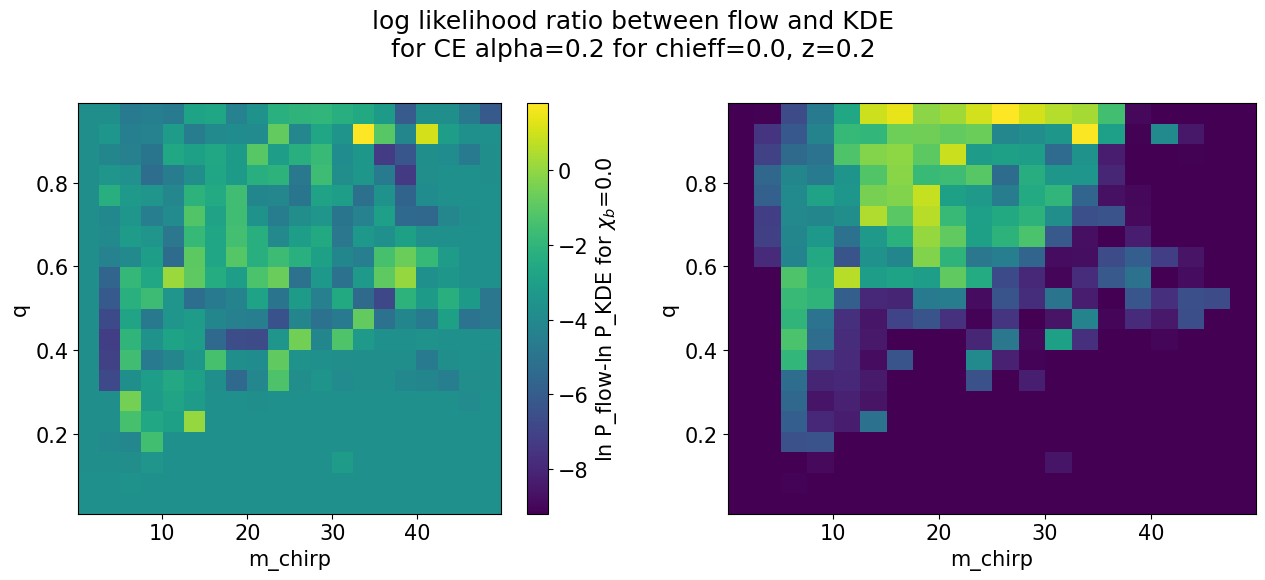

In [55]:
plt.rcParams["figure.figsize"] = (13,6)
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1,2)
ratio = flow_likelihood[:,:]-kde_likelihood[:,:]
#oldratio = strict_reg_flow[chibid, alphaid,:,:]-strct_reg_KDE[chibid, alphaid,:,:]
c = ax[0].imshow(np.swapaxes(ratio, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto')
c = ax[1].imshow(np.swapaxes(flow_likelihood, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', aspect='auto')

cbar = fig.colorbar(c, ax=ax[0])
cbar.set_label(fr'ln P_flow-ln P_KDE for $\chi_b$={chi_b[chibid]}')
#c = ax[chibid,1].imshow(np.swapaxes(oldratio, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto')


ax[0].set_xlabel(fr'm_chirp')
ax[1].set_xlabel(fr'm_chirp')
ax[0].set_ylabel(fr'q')

""" bin_width = 0.05
chieffs = models_dict[(chibid,alphaid)][:]['chieff']
zs = models_dict[(chibid,alphaid)][:]['z']
bin_chieff = np.logical_and(chieffs>0.0 - 2*bin_width,  chieffs< 0.0 + 2*bin_width)
bin_z = np.logical_and(zs>0.2 - 10*bin_width, zs < 0.2 + 10*bin_width)
bin_conditions = np.logical_and(bin_chieff, bin_z)

c = ax[chibid,1].imshow(np.swapaxes(ratio,0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto', zorder=-200)

corner.hist2d(np.array(models_dict[(chibid,alphaid)][bin_conditions]['mchirp']), np.array(models_dict[(chibid,alphaid)][bin_conditions]['q']),\
        weights=np.array(weights_dict[(chibid,alphaid)][bin_conditions]), alpha=0.5, density=True, ax=ax[chibid,1], no_fill_contours=True)
"""
ax[1].set_xlim(mchirps[0], mchirps[-1])
ax[1].set_ylim(qs[0], qs[-1])
ax[1].set_xlabel(fr'm_chirp')
ax[1].set_ylabel(fr'q')
fig.suptitle('log likelihood ratio between flow and KDE''\n'fr'for CE alpha={alpha[alphaid]} for chieff=0.0, z=0.2')
fig.tight_layout(pad=1.3)
#fig.savefig(f'llh_ratio/slices/CE2Dmchirpq_chi0_z02_alpha{alpha[alphaid]}.pdf')

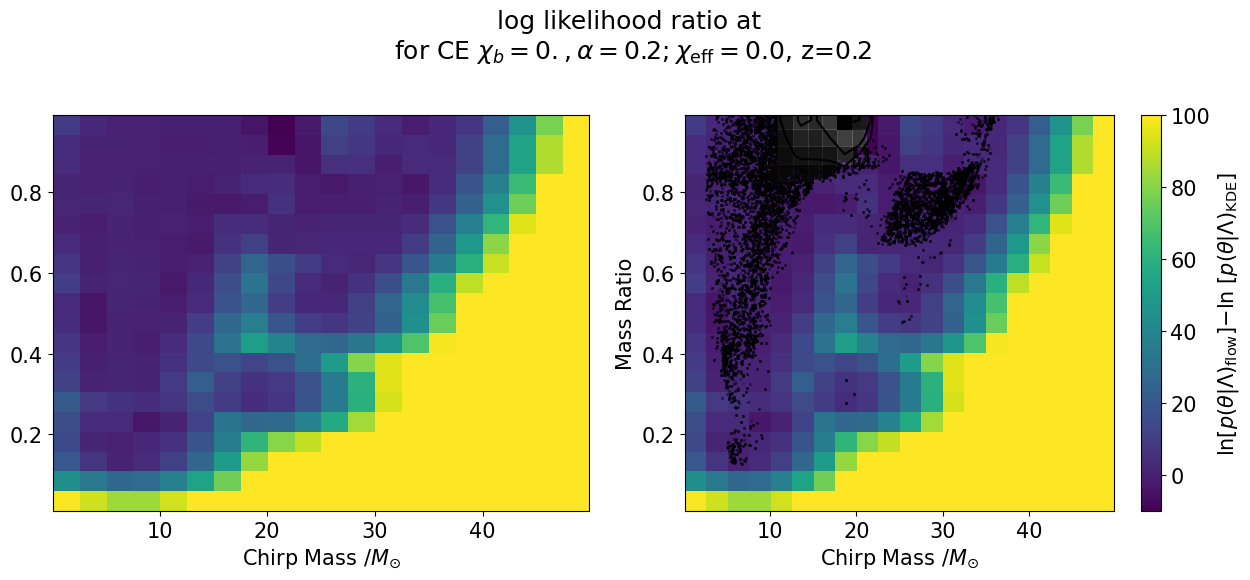

In [52]:
plt.rcParams["figure.figsize"] = (13,6)
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(1,2)

ratio = p_mchirpq[0, 0,:,:]-p_mchirpq_kde[0, 0,:,:]
#oldratio = strict_reg_flow[chibid, alphaid,:,:]-strct_reg_KDE[chibid, alphaid,:,:]
c = ax[0].imshow(np.swapaxes(ratio, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-10, vmax=100, aspect='auto')
cbar = fig.colorbar(c, ax=ax[1])
cbar.set_label(r'ln[$p(\theta\|\Lambda)_{\mathrm{flow}}] \minus$ln [$p(\theta\|\Lambda)_{\mathrm{KDE}}$]')
#c = ax[chibid,1].imshow(np.swapaxes(oldratio, 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-6, vmax=6, aspect='auto')


ax[0].set_xlabel(fr'{param_label[0]}')
ax[1].set_xlabel(fr'{param_label[0]}')
ax[1].set_ylabel(fr'{param_label[1]}')

chibid=0
alphaid=0

bin_width = 0.05
chieffs = models_dict[(chibid,alphaid)][:]['chieff']
zs = models_dict[(chibid,alphaid)][:]['z']
bin_chieff = np.logical_and(chieffs>0.0 - 2*bin_width,  chieffs< 0.0 + 2*bin_width)
bin_z = np.logical_and(zs>0.2 - 10*bin_width, zs < 0.2 + 10*bin_width)
bin_conditions = np.logical_and(bin_chieff, bin_z)

c = ax[1].imshow(np.swapaxes(ratio,0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-10, vmax=100, aspect='auto', zorder=-200)

corner.hist2d(np.array(models_dict[(chibid,alphaid)][bin_conditions]['mchirp']), np.array(models_dict[(chibid,alphaid)][bin_conditions]['q']),\
        weights=np.array(weights_dict[(chibid,alphaid)][bin_conditions]), alpha=0.5, density=True, ax=ax[1], no_fill_contours=True)
ax[1].set_xlim(mchirps[0], mchirps[-1])
ax[1].set_ylim(qs[0], qs[-1])
fig.suptitle('log likelihood ratio at ''\n'r'for CE $\chi_b=0., \alpha=0.2; \chi_{\mathrm{eff}}=$0.0, z=0.2')
fig.tight_layout(pad=1.3)
#fig.savefig(f'llh_ratio/slices/CE2Dmchirpq_chi0_z02_alpha{alpha[alphaid]}.pdf')

## 4D plot of ratio

In [18]:
mchirps = np.linspace(0.1,65.,10)
qs = np.linspace(0.01,0.99,10)
chieffs = np.linspace(-0.5,0.99,10)
zs = np.linspace(0.01,6.,10)

p_mchirpqchiz = np.zeros((4,10,10,10,10))
p_mchirpqchiz_kde = np.zeros((4,10,10,10,10))

chi_b=[0.,0.1]
alphaCEid = 4
for chibid, xb in enumerate(chi_b):
    for  i, m in enumerate(mchirps):
        for j, q in enumerate(qs):
            for  x, chi in enumerate(chieffs):
                for y, z in enumerate(zs):
                    sample = np.reshape([m, q, chi, z], (1,1,4))
                    p_mchirpqchiz[chibid, i, j, x, y] = samp.lnlike([xb, alpha[alphaCEid], 0.5,0.05,0.2,0.1], sample, flow, submodels_dict, channels, use_flows=True, prior_pdf=None, use_reg=True)
                    p_mchirpqchiz_kde[chibid, i, j, x, y] = samp.lnlike([chibid, alphaCEid,0.5,0.05,0.2,0.1], sample, KDE, submodels_dict, channels, use_flows=False, prior_pdf=None,use_reg=True)

In [28]:
np.save('llh_ratio/slices/NSC4Dllh_flows_150124_extralong.pdf', p_mchirpqchiz)
np.save('llh_ratio/slices/NSC4Dllh_KDEs.pdf', p_mchirpqchiz_kde)


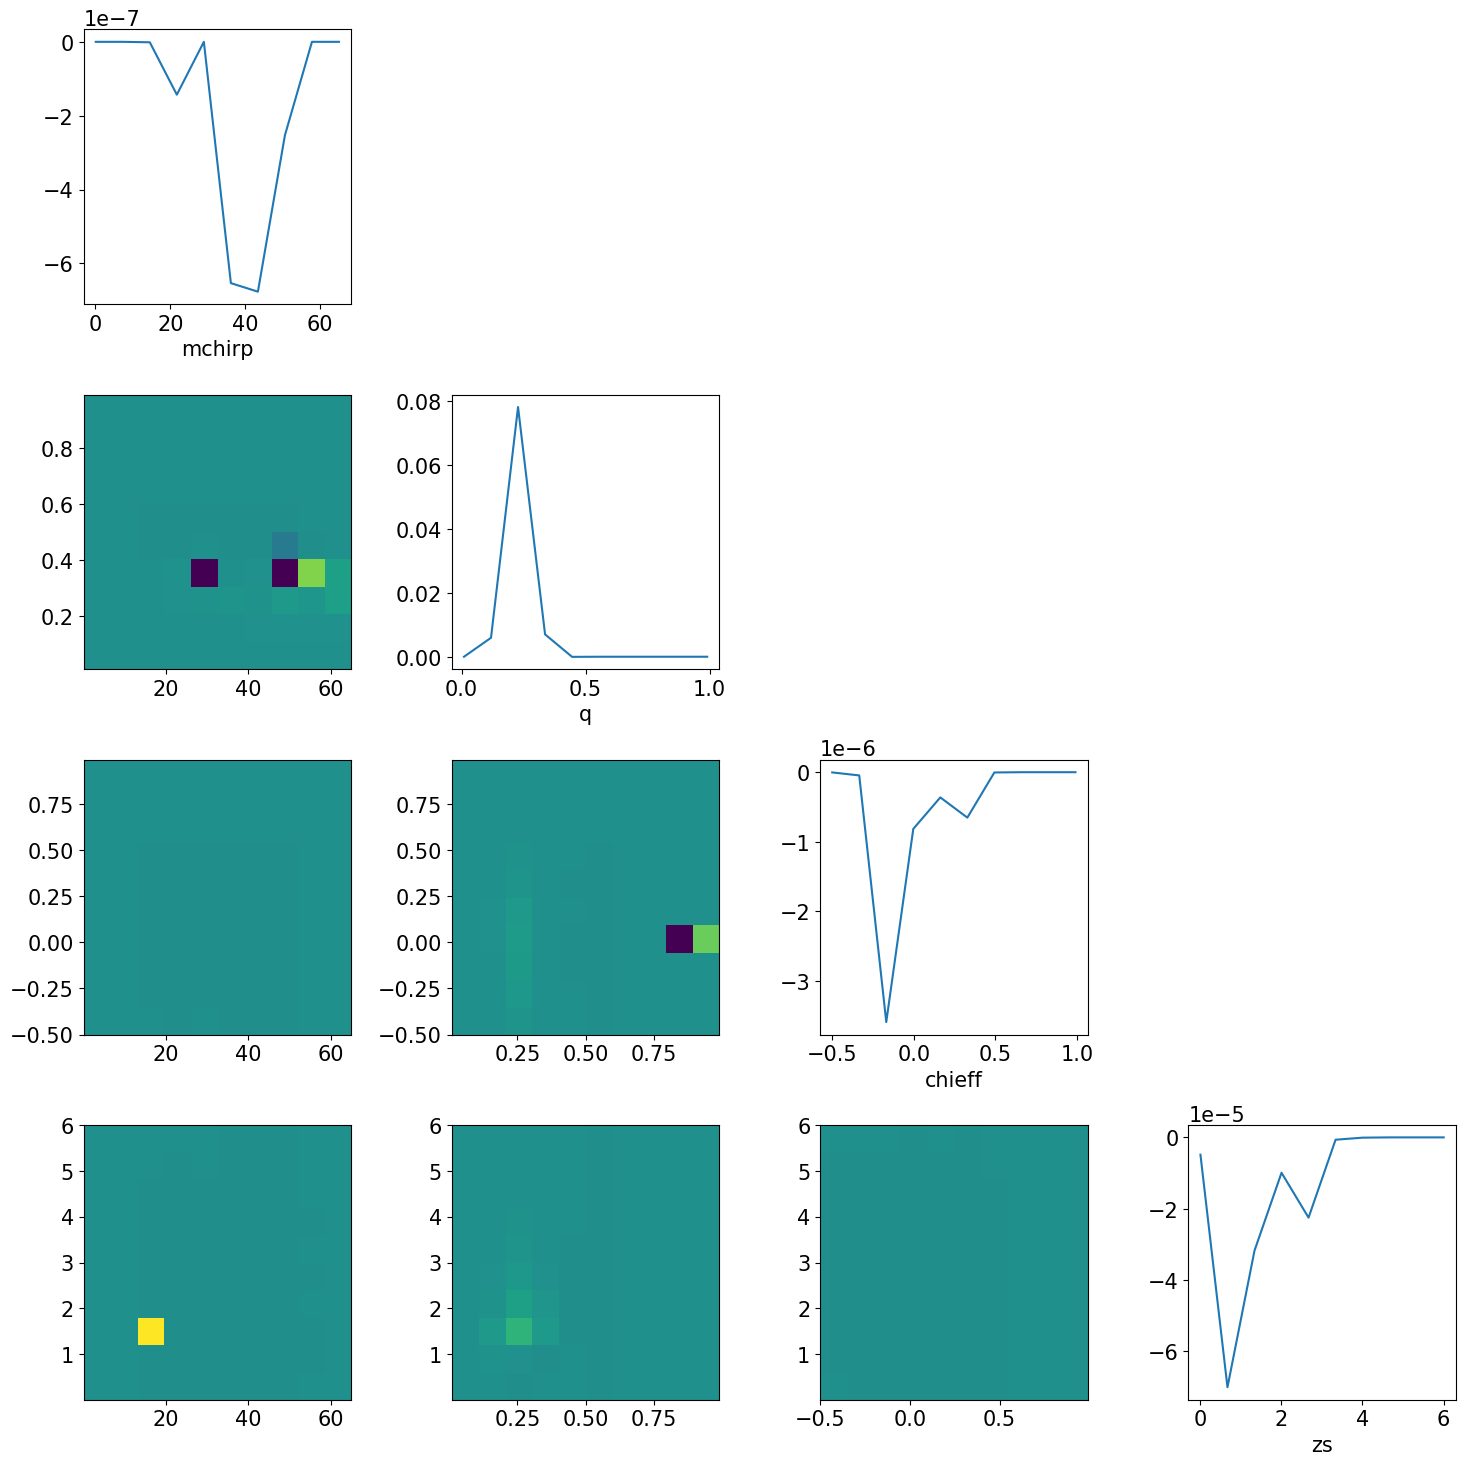

In [29]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 15})
fig,ax=plt.subplots(4,4)
chibid = 0


ratio = p_mchirpqchiz[chibid,:,:,:,:]-p_mchirpqchiz_kde[chibid,:,:,:,:]
ax[0,0].plot(mchirps, ratio[:, 5, 5, 5])
ax[0,0].set_xlabel('mchirp')
ax[1,1].plot(qs, ratio[5, :, 5, 5])
ax[1,1].set_xlabel('q')
ax[2,2].plot(chieffs, ratio[5, 5, :, 5])
ax[2,2].set_xlabel('chieff')
ax[3,3].plot(zs, ratio[5, 5, 5, :])
ax[3,3].set_xlabel('zs')

ax[0,1].set_axis_off()
ax[0,2].set_axis_off()
ax[1,2].set_axis_off()
ax[0,3].set_axis_off()
ax[1,3].set_axis_off()
ax[2,3].set_axis_off()

cbarmin=2

c = ax[1,0].imshow(np.swapaxes(ratio[:,:,5,5], 0,1), extent=(mchirps[0], mchirps[-1], qs[0], qs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[2,0].imshow(np.swapaxes(ratio[:,5,:,5], 0,1), extent=(mchirps[0], mchirps[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[2,1].imshow(np.swapaxes(ratio[5,:,:,5], 0,1), extent=(qs[0], qs[-1], chieffs[0], chieffs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,0].imshow(np.swapaxes(ratio[:,5,5,:], 0,1), extent=(mchirps[0], mchirps[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin,  aspect='auto')
c = ax[3,1].imshow(np.swapaxes(ratio[5,:,5,:], 0,1), extent=(qs[0], qs[-1], zs[0], zs[-1]), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')
c = ax[3,2].imshow(np.swapaxes(ratio[5,5,:,:], 0,1), extent=(chieffs[0], chieffs[-1], zs[0], zs[-1], ), origin='lower', vmin=-cbarmin, vmax=cbarmin, aspect='auto')


fig.tight_layout(pad=1.3)

#cbar = fig.colorbar(c, ax=ax[1,0])

In [23]:
np.max(ratio[:,:,:,:])

4.49845994218054